# Implementing an RNN in TensorFlow
----------------------------------

This script implements an RNN in TensorFlow to predict spam/ham from texts.

We start by loading the necessary libraries and initializing a computation graph in TensorFlow.

In [22]:
import os
import re
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from zipfile import ZipFile
from tensorflow.python.framework import ops
ops.reset_default_graph()

# Start a graph
sess = tf.Session()

Next we set the parameters for the RNN model.

In [23]:
# Set RNN parameters
epochs = 50
batch_size = 250
max_sequence_length = 25
rnn_size = 10
embedding_size = 50
min_word_frequency = 10
learning_rate = 0.0005
dropout_keep_prob = tf.placeholder(tf.float32)

We download and save the data next.  First we check if we have saved it before and load it locally, if not, we load it from the internet (UCI machine learning data repository).

In [24]:
# Download or open data
data_dir = 'temp'
data_file = 'text_data.txt'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

if not os.path.isfile(os.path.join(data_dir, data_file)):
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    # Format Data
    text_data = file.decode()
    text_data = text_data.encode('ascii', errors='ignore')
    text_data = text_data.decode().split('\n')

    # Save data to text file
    with open(os.path.join(data_dir, data_file), 'w') as file_conn:
        for text in text_data:
            file_conn.write("{}\n".format(text))
else:
    # Open data from text file
    text_data = []
    with open(os.path.join(data_dir, data_file), 'r') as file_conn:
        for row in file_conn:
            text_data.append(row)
    text_data = text_data[:-1]

text_data = [x.split('\t') for x in text_data if len(x) >= 1]
[text_data_target, text_data_train] = [list(x) for x in zip(*text_data)]

Next, we process the texts and turn them into numeric representations (words --> indices).

In [25]:
# Create a text cleaning function
def clean_text(text_string):
    text_string = re.sub(r'([^\s\w]|_|[0-9])+', '', text_string)
    text_string = " ".join(text_string.split())
    text_string = text_string.lower()
    return text_string


# Clean texts
text_data_train = [clean_text(x) for x in text_data_train]

# Change texts into numeric vectors
vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(max_sequence_length,
                                                                     min_frequency=min_word_frequency)
text_processed = np.array(list(vocab_processor.fit_transform(text_data_train)))

> Note: there will be a WARNING:... use tensorflow/transform or tf.data.  Ignore this for now- there is an issue with getting tensorflow/transform to work. Hopefully this will be fixed soon and the code here will be updated.

Now we shuffle and split the texts into train/tests (80% training, 20% testing).

In [26]:
# Shuffle and split data
text_processed = np.array(text_processed)
text_data_target = np.array([1 if x == 'ham' else 0 for x in text_data_target])
shuffled_ix = np.random.permutation(np.arange(len(text_data_target)))
x_shuffled = text_processed[shuffled_ix]
y_shuffled = text_data_target[shuffled_ix]

# Split train/test set
ix_cutoff = int(len(y_shuffled)*0.80)
x_train, x_test = x_shuffled[:ix_cutoff], x_shuffled[ix_cutoff:]
y_train, y_test = y_shuffled[:ix_cutoff], y_shuffled[ix_cutoff:]
vocab_size = len(vocab_processor.vocabulary_)
print("Vocabulary Size: {:d}".format(vocab_size))
print("80-20 Train Test split: {:d} -- {:d}".format(len(y_train), len(y_test)))

Vocabulary Size: 933
80-20 Train Test split: 4459 -- 1115


Here we can define our RNN model.  We create the placeholders for the data, word embedding matrices (and embedding lookups), and define the rest of the model.

The rest of the RNN model will create a dynamic RNN cell (regular RNN type), which will vary the number of RNNs needed for variable input length (different amount of words for input texts), and then output into a fully connected logistic layer to predict spam or ham as output.

In [27]:
# Create placeholders
x_data = tf.placeholder(tf.int32, [None, max_sequence_length])
y_output = tf.placeholder(tf.int32, [None])

print('x_data:', x_data)
print('y_output:', y_output)

# Create embedding
embedding_mat = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0))
embedding_output = tf.nn.embedding_lookup(embedding_mat, x_data)

print('embedding_mat:',embedding_mat)
print('embedding_output:',embedding_output)

# Define the RNN cell
# tensorflow change >= 1.0, rnn is put into tensorflow.contrib directory. Prior version not test.
if tf.__version__[0] >= '1':
    cell = tf.contrib.rnn.BasicRNNCell(num_units=rnn_size)
else:
    cell = tf.nn.rnn_cell.BasicRNNCell(num_units=rnn_size)

print(cell)
output, state = tf.nn.dynamic_rnn(cell, embedding_output, dtype=tf.float32)
output = tf.nn.dropout(output, dropout_keep_prob)

# Get output of RNN sequence
output = tf.transpose(output, [1, 0, 2])
last = tf.gather(output, int(output.get_shape()[0]) - 1)

weight = tf.Variable(tf.truncated_normal([rnn_size, 2], stddev=0.1))
bias = tf.Variable(tf.constant(0.1, shape=[2]))
logits_out = tf.matmul(last, weight) + bias

x_data: Tensor("Placeholder_1:0", shape=(?, 25), dtype=int32)
y_output: Tensor("Placeholder_2:0", shape=(?,), dtype=int32)
embedding_mat: <tf.Variable 'Variable:0' shape=(933, 50) dtype=float32_ref>
embedding_output: Tensor("embedding_lookup:0", shape=(?, 25, 50), dtype=float32)


Next we declare the loss function (softmax cross entropy), an accuracy function, and optimization function (RMSProp).

In [28]:
# Loss function
losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_out, labels=y_output)
loss = tf.reduce_mean(losses)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits_out, 1), tf.cast(y_output, tf.int64)), tf.float32))

optimizer = tf.train.RMSPropOptimizer(learning_rate)
train_step = optimizer.minimize(loss)

> You may ignore the warning, as the texts are small and our batch size is only 100.  If you increase the batch size and/or have longer sequences of texts, this model may consume too much memory.

Next we initialize the variables in the computational graph.

In [29]:
init = tf.global_variables_initializer()
sess.run(init)

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

Now we can start our training!

In [30]:
# Start training
for epoch in range(epochs):

    # Shuffle training data
    shuffled_ix = np.random.permutation(np.arange(len(x_train)))
    x_train = x_train[shuffled_ix]
    y_train = y_train[shuffled_ix]
    num_batches = int(len(x_train)/batch_size) + 1
    # TO DO CALCULATE GENERATIONS ExACTLY
    for i in range(num_batches):
        # Select train data
        min_ix = i * batch_size
        max_ix = np.min([len(x_train), ((i+1) * batch_size)])
        x_train_batch = x_train[min_ix:max_ix]
        y_train_batch = y_train[min_ix:max_ix]
        
        # Run train step
        train_dict = {x_data: x_train_batch, y_output: y_train_batch, dropout_keep_prob:0.5}
        sess.run(train_step, feed_dict=train_dict)
        
    # Run loss and accuracy for training
    temp_train_loss, temp_train_acc = sess.run([loss, accuracy], feed_dict=train_dict)
    train_loss.append(temp_train_loss)
    train_accuracy.append(temp_train_acc)
    
    # Run Eval Step
    test_dict = {x_data: x_test, y_output: y_test, dropout_keep_prob:1.0}
    temp_test_loss, temp_test_acc = sess.run([loss, accuracy], feed_dict=test_dict)
    test_loss.append(temp_test_loss)
    test_accuracy.append(temp_test_acc)
    print('Epoch: {}, Test Loss: {:.2}, Test Acc: {:.2}'.format(epoch+1, temp_test_loss, temp_test_acc))

Epoch: 1, Test Loss: 0.6, Test Acc: 0.83
Epoch: 2, Test Loss: 0.58, Test Acc: 0.83
Epoch: 3, Test Loss: 0.55, Test Acc: 0.83
Epoch: 4, Test Loss: 0.52, Test Acc: 0.83
Epoch: 5, Test Loss: 0.48, Test Acc: 0.84
Epoch: 6, Test Loss: 0.45, Test Acc: 0.84
Epoch: 7, Test Loss: 0.43, Test Acc: 0.84
Epoch: 8, Test Loss: 0.42, Test Acc: 0.84
Epoch: 9, Test Loss: 0.41, Test Acc: 0.84
Epoch: 10, Test Loss: 0.41, Test Acc: 0.85
Epoch: 11, Test Loss: 0.4, Test Acc: 0.85
Epoch: 12, Test Loss: 0.4, Test Acc: 0.85
Epoch: 13, Test Loss: 0.4, Test Acc: 0.86
Epoch: 14, Test Loss: 0.4, Test Acc: 0.86
Epoch: 15, Test Loss: 0.39, Test Acc: 0.86
Epoch: 16, Test Loss: 0.39, Test Acc: 0.86
Epoch: 17, Test Loss: 0.39, Test Acc: 0.86
Epoch: 18, Test Loss: 0.39, Test Acc: 0.87
Epoch: 19, Test Loss: 0.38, Test Acc: 0.87
Epoch: 20, Test Loss: 0.38, Test Acc: 0.87
Epoch: 21, Test Loss: 0.37, Test Acc: 0.87
Epoch: 22, Test Loss: 0.37, Test Acc: 0.87
Epoch: 23, Test Loss: 0.36, Test Acc: 0.87
Epoch: 24, Test Loss: 0.3

Here is matplotlib code to plot the loss and accuracy over the training generations for both the train and test sets.

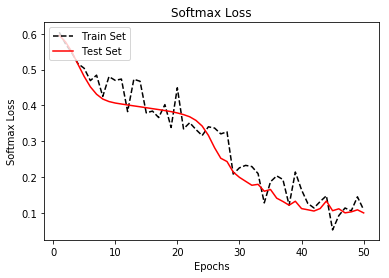

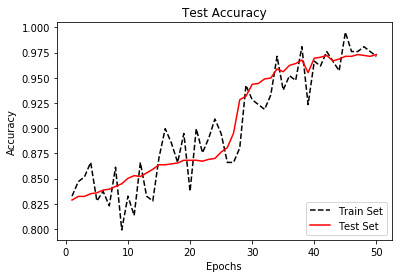

In [31]:
%matplotlib inline

# Plot loss over time
epoch_seq = np.arange(1, epochs+1)
plt.plot(epoch_seq, train_loss, 'k--', label='Train Set')
plt.plot(epoch_seq, test_loss, 'r-', label='Test Set')
plt.title('Softmax Loss')
plt.xlabel('Epochs')
plt.ylabel('Softmax Loss')
plt.legend(loc='upper left')
plt.show()

# Plot accuracy over time
plt.plot(epoch_seq, train_accuracy, 'k--', label='Train Set')
plt.plot(epoch_seq, test_accuracy, 'r-', label='Test Set')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Evaluating New Texts

Here, we show how to use our trained model to evaluate new texts (which may or may not be spam/ham)

In [68]:
sample_texts = ['Hi, please respond 1111 asap to claim your change to win now!',
                'Hey what are you doing for dinner tonight?',
                'New offer, show this text for 50% off of our inagural sale!',
                'Can you take the dog to the vet tomorrow?',
                'Congratulations! You have been randomly selected to receive account credit!',
                'Mr Hanh would not be able to pass the deep learning class',
                'Congratulate,you have a fotune to win a lottery claim win now!']

Now we clean our sample texts.

In [69]:
clean_texts = [clean_text(text) for text in sample_texts]
print(clean_texts)

['hi please respond asap to claim your change to win now', 'hey what are you doing for dinner tonight', 'new offer show this text for off of our inagural sale', 'can you take the dog to the vet tomorrow', 'congratulations you have been randomly selected to receive account credit', 'mr hanh would not be able to pass the deep learning class', 'congratulateyou have a fotune to win a lottery claim win now']


Next, we transform each text as a sequence of words into a sequence of vocabulary indices.

In [70]:
processed_texts = np.array(list(vocab_processor.transform(clean_texts)))
print(processed_texts)

[[ 93  99   0   0   1 114  13 524   1 178  21   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [121  52  20   3 151  12 332 208   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [ 92 376 483  39  69  12 203  15  86   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [ 28   3 104   5   0   1   5   0 143   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [701   3  17  98   0 420   1 318 301 738   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [857   0 172  24  32 459   1 909   5   0   0 264   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [  0  17   4   0   1 178   4   0 114 178  21   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]]


Now we can run each of the texts through our model and get the output logits.

In [71]:
# Remember to wrap the resulting logits in a softmax to get probabilities
eval_feed_dict = {x_data: processed_texts, dropout_keep_prob: 1.0}
model_results = sess.run(tf.nn.softmax(logits_out), feed_dict=eval_feed_dict)

print(model_results)

[[0.80528575 0.19471423]
 [0.0093527  0.99064726]
 [0.17758939 0.82241064]
 [0.0093527  0.99064726]
 [0.04899374 0.9510063 ]
 [0.00935378 0.99064624]
 [0.8036053  0.19639468]]


Now print results

In [72]:
categories = ['spam', 'ham']

for ix, result in enumerate(model_results):
    prediction = categories[np.argmax(result)]
    
    print('Text: {}, \nPrediction: {}\n'.format(sample_texts[ix], prediction))

Text: Hi, please respond 1111 asap to claim your change to win now!, 
Prediction: spam

Text: Hey what are you doing for dinner tonight?, 
Prediction: ham

Text: New offer, show this text for 50% off of our inagural sale!, 
Prediction: ham

Text: Can you take the dog to the vet tomorrow?, 
Prediction: ham

Text: Congratulations! You have been randomly selected to receive account credit!, 
Prediction: ham

Text: Mr Hanh would not be able to pass the deep learning class, 
Prediction: ham

Text: Congratulate,you have a fotune to win a lottery claim win now!, 
Prediction: spam

